# Project Evaluation Criteria

## Data Loading and Preprocessing (2 points max)
- Load the data from the CSV files using the appropriate data import methods in PyTorch.
- Apply dataset splits that enable you to assess network overfitting.
- Preprocess the categorical and numerical data accordingly (refer to **Lesson 5 – Training Practices and Regularization** and **Lesson 6 – PyTorch in Production**).
- Make data loading protocols for mini-batch training.

## Approach and Methodology (2 points max)
- Implement a neural network architecture suited to the task and justify your choice (refer to **Lesson 6 – PyTorch in Production**).
- Apply regularization techniques that help prevent network overfitting.

## Results and Evaluation (2 points max)
- Build a training protocol to train your neural network on the dataset with a user-specified number of epochs.
- Implement methods that effectively regulate the training process (refer to **Lab 5 – Training Practices and Regularization**).
- Provide visualizations, if useful, that give an indication of the training procedure (e.g., a loss curve). These visualizations can be included in your report as part of your submission package.
- Implement a software method that saves the network’s weight with the best performance.  
  - These network weights should be saved as `.pt` / `.pth` file.
  - Include them as part of your submission package so that the teacher and the teaching assistant can reproduce your results. 

## Code Quality and Reproducibility (2 points max)
- Your code should be clean, well-structured, and properly commented.
- Ensure the code runs in inference mode with your network weights (`.pt` / `.pth` file) to produce the target variable (the number of rings) using the data from `test.csv`.
- Ensure that the model generates predictions for the number of rings for every data point in the test set.
- Write a `README` file for running your code in inference mode to produce the targets.  
  - This will help the teacher and the teaching assistant reproduce your results. 

## Summary and Justification (2 points max)
- Clearly summarize the key novelties of your approach.
- Justify the choices made in the data preprocessing, neural network design, training protocol, and inference protocol.
- Discuss any challenges encountered and potential improvements.

## Importing the data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

We will choose to use standardization because it includes the variance of the score. As we can see from the data ranges there may be outliers. And outliers may affect the the score a lot when we use the normalization route. We will only do this for the numerical columns and not the categorical column "Sex".

### Load and initiate the data

To prevent clutter we have moved the loading of the data to the file data_load.py. The loading of the data should not change because the data stays constant. All of  the other functions could change, therefore we leave them in the notebooks for easier change of functions. 

In [2]:
from data_load import AbalonDataset

def load_data(batch_size):

    train_dataset, test_dataset = AbalonDataset.create_train_test_val("train.csv")
    val_dataset = AbalonDataset.create_train_test_val("test.csv", train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(test_dataset, batch_size=batch_size)
    test_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader



## Setup model

In [3]:
import torch.nn as nn


class AbaloneNetwork(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_outputs))

    def forward(self, x):
        return self.model(x)


## Setup the training cycle of the model

In [14]:
def l1_regularization(model, lambda_reg):
    l1_penalty = sum(param.abs().sum() for param in model.parameters())
    return lambda_reg * l1_penalty

def train_model(model, train_loader, optimizer, device, criterion, val_loader, lambda_reg=None):
    model.train()
    train_loss = 0.0

    for inputs_load, targets_load in train_loader:
        inputs, targets = inputs_load.to(device), targets_load.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # only do regularization when lambda_reg has been passed to it.
        if lambda_reg is not None:
            loss += l1_regularization(model, lambda_reg)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Compute average train loss

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        

        
        val_loss /= len(val_loader)  # Compute average validation loss
    return train_loss, val_loss





## Plot the model results


In [5]:
def plot_figure(numepochs, trainlosses, vallosses):
    # Plot the loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, numepochs + 1), trainlosses, label="Train Loss", marker="o")
    plt.plot(range(1, numepochs + 1), vallosses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

## Train the complete model for its epochs

In [45]:
from statistics import mean
def train_setup_epochs(train_loader, val_loader, model, optimizer, device, criterion, num_epochs, lambda_reg=None, stop_converge = False):
    
    best_val_loss = float("inf")

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss, val_loss = train_model(model, train_loader, optimizer, device, criterion, val_loader, lambda_reg)
        train_losses.append(train_loss)
        val_losses.append(val_loss)


        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, "best_model.pth")
            print("Saved Best Model")
        
        # if the mean of the previous three epochs is not improving anymore we stop. if improvement is less than 0.1% we stop
        if stop_converge:
            previous_3_epochs = val_losses[max(0, epoch-3): epoch]
            if previous_3_epochs:
                if val_loss *1.0001 > mean(previous_3_epochs) or val_loss *0.9999 > mean(previous_3_epochs):
                    print("model converged, it stopped improving at epoch: ", epoch)
                    break
    return train_losses, val_losses, epoch +1

In [33]:
from statistics import mean
value_epoch = 4
previous_3_epochs = [7,6,5,4,4,4,4][max(0, epoch-3): epoch]
if previous_3_epochs:
    if value_epoch < mean(previous_3_epochs):
        print("model converged, it stopped improving")
        


model converged, it stopped improving


/Users/mehdigreefhorst/Desktop/DeepLearning1stAssignment-abalone/data_load.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


Epoch 1/20, Train Loss: 9.4408, Val Loss: 9.2212
Saved Best Model
Epoch 2/20, Train Loss: 8.7150, Val Loss: 8.3760
Saved Best Model
Epoch 3/20, Train Loss: 7.7008, Val Loss: 7.1642
Saved Best Model
Epoch 4/20, Train Loss: 6.2718, Val Loss: 5.5297
Saved Best Model
Epoch 5/20, Train Loss: 4.4792, Val Loss: 3.6669
Saved Best Model
Epoch 6/20, Train Loss: 2.7509, Val Loss: 2.2383
Saved Best Model
Epoch 7/20, Train Loss: 1.9083, Val Loss: 1.8673
Saved Best Model
Epoch 8/20, Train Loss: 1.7608, Val Loss: 1.8121
Saved Best Model
Epoch 9/20, Train Loss: 1.7365, Val Loss: 1.7949
Saved Best Model
Epoch 10/20, Train Loss: 1.7263, Val Loss: 1.7842
Saved Best Model
Epoch 11/20, Train Loss: 1.7191, Val Loss: 1.7748
Saved Best Model
Epoch 12/20, Train Loss: 1.7125, Val Loss: 1.7664
Saved Best Model
Epoch 13/20, Train Loss: 1.7068, Val Loss: 1.7588
Saved Best Model
Epoch 14/20, Train Loss: 1.7012, Val Loss: 1.7510
Saved Best Model
Epoch 15/20, Train Loss: 1.6958, Val Loss: 1.7433
Saved Best Model
Epoc

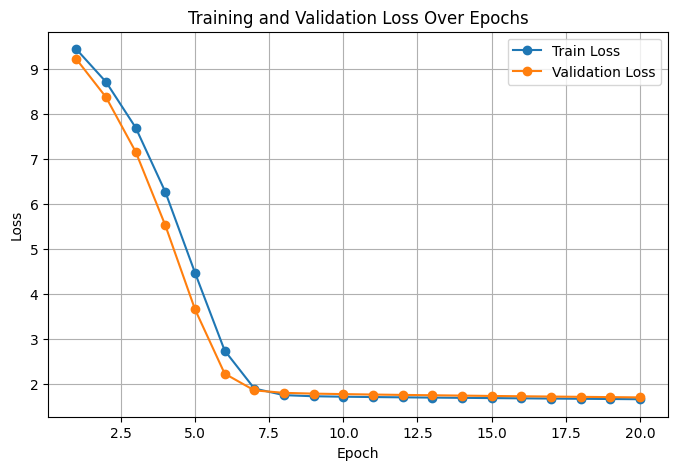

In [ ]:
trainloader, valloader, testloader = load_data(batch_size=32)
model_abalone = AbaloneNetwork(10, 10, 1)
device = torch.device("cpu")
model_abalone.to(device)
criterion_l1 = nn.L1Loss()
optimizer_sgd = optim.SGD(model_abalone.parameters(), lr=5e-3, weight_decay=1e-6)
epochs = 20
train_loss_list, val_loss_list, epochs_done = train_setup_epochs(train_loader = trainloader,
                                                    val_loader=valloader, 
                                                    model=model_abalone, 
                                                    optimizer=optimizer_sgd, 
                                                    device=device, 
                                                    criterion=criterion_l1, 
                                                    num_epochs=epochs)
plot_figure(epochs_done, train_loss_list, val_loss_list)

## Try with smaller batch size

Interestingly, decreasing the batch size leads to a better performance while taking a bit longer to compute 

/Users/mehdigreefhorst/Desktop/DeepLearning1stAssignment-abalone/data_load.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


Epoch 1/10, Train Loss: 2.5676, Val Loss: 1.5394
Saved Best Model
Epoch 2/10, Train Loss: 1.6591, Val Loss: 1.5217
Saved Best Model
Epoch 3/10, Train Loss: 1.6202, Val Loss: 1.4895
Saved Best Model
Epoch 4/10, Train Loss: 1.5895, Val Loss: 1.4465
Saved Best Model
Epoch 5/10, Train Loss: 1.5747, Val Loss: 1.4388
Saved Best Model
Epoch 6/10, Train Loss: 1.5575, Val Loss: 1.4083
Saved Best Model
Epoch 7/10, Train Loss: 1.5462, Val Loss: 1.3928
Saved Best Model
Epoch 8/10, Train Loss: 1.5360, Val Loss: 1.4050
Epoch 9/10, Train Loss: 1.5345, Val Loss: 1.3779
Saved Best Model
Epoch 10/10, Train Loss: 1.5250, Val Loss: 1.3851


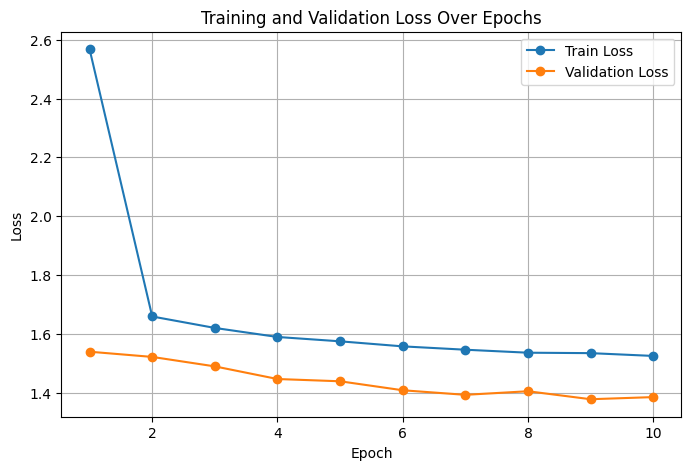

In [ ]:
trainloader, valloader, testloader = load_data(batch_size=1)
model_abalone = AbaloneNetwork(10, 10, 1)
device = torch.device("cpu")
model_abalone.to(device)
criterion_l1 = nn.L1Loss()
optimizer_sgd = optim.SGD(model_abalone.parameters(), lr=5e-3, weight_decay=1e-6)
epochs = 10
train_loss_list, val_loss_list, epochs_done = train_setup_epochs(train_loader = trainloader,
                                                    val_loader=valloader, 
                                                    model=model_abalone, 
                                                    optimizer=optimizer_sgd, 
                                                    device=device, 
                                                    criterion=criterion_l1, 
                                                    num_epochs=epochs)
plot_figure(epochs_done, train_loss_list, val_loss_list)

## Let's see what happens when we add another hidden layer that is fully connected

We are also using momentum now

In [11]:
class AbaloneNetworkTwoLayer(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_outputs))

    def forward(self, x):
        return self.model(x)


/Users/mehdigreefhorst/Desktop/DeepLearning1stAssignment-abalone/data_load.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


Epoch 1/30, Train Loss: 5.7110, Val Loss: 1.8913
Saved Best Model
Epoch 2/30, Train Loss: 1.7798, Val Loss: 1.7547
Saved Best Model
Epoch 3/30, Train Loss: 1.7142, Val Loss: 1.6906
Saved Best Model
Epoch 4/30, Train Loss: 1.6630, Val Loss: 1.6281
Saved Best Model
Epoch 5/30, Train Loss: 1.6279, Val Loss: 1.5872
Saved Best Model
Epoch 6/30, Train Loss: 1.6130, Val Loss: 1.5656
Saved Best Model
Epoch 7/30, Train Loss: 1.5971, Val Loss: 1.5496
Saved Best Model
Epoch 8/30, Train Loss: 1.5732, Val Loss: 1.5259
Saved Best Model
Epoch 9/30, Train Loss: 1.5508, Val Loss: 1.5027
Saved Best Model
Epoch 10/30, Train Loss: 1.5347, Val Loss: 1.4901
Saved Best Model
Epoch 11/30, Train Loss: 1.5164, Val Loss: 1.4824
Saved Best Model
Epoch 12/30, Train Loss: 1.5065, Val Loss: 1.4716
Saved Best Model
Epoch 13/30, Train Loss: 1.4946, Val Loss: 1.4636
Saved Best Model
Epoch 14/30, Train Loss: 1.4893, Val Loss: 1.4692
Epoch 15/30, Train Loss: 1.4793, Val Loss: 1.4624
Saved Best Model
Epoch 16/30, Train Lo

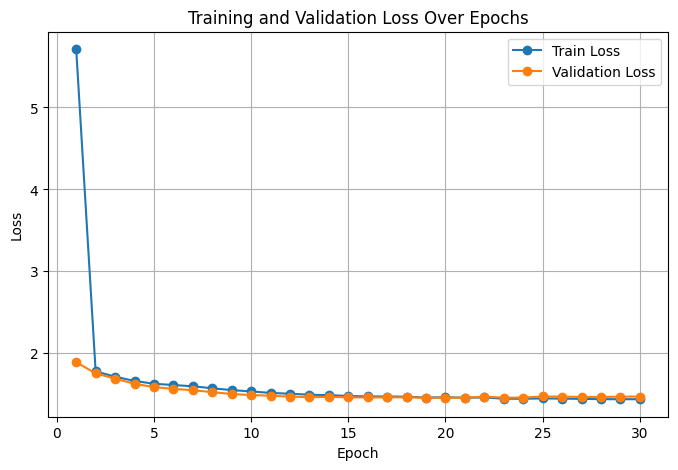

In [ ]:
trainloader, valloader, testloader = load_data(batch_size=32)
model_abalone = AbaloneNetworkTwoLayer(10, 12, 1)
device = torch.device("cpu")
model_abalone.to(device)
criterion_l1 = nn.L1Loss()
optimizer_sgd = optim.SGD(model_abalone.parameters(), lr=5e-3, weight_decay=1e-6, momentum=0.9)
epochs = 30
train_loss_list, val_loss_list, epochs_done = train_setup_epochs(train_loader = trainloader,
                                                    val_loader=valloader, 
                                                    model=model_abalone, 
                                                    optimizer=optimizer_sgd, 
                                                    device=device, 
                                                    criterion=criterion_l1, 
                                                    num_epochs=epochs)
plot_figure(epochs_done, train_loss_list, val_loss_list)

### Choice of layers
as it seems the number of layers doesn't affect the prediction score, so we'll only implement a single layer

### Implement regularization

We choose to implement L1 regularization. As we are also using the L1 loss, so this seems like a smart choice

/Users/mehdigreefhorst/Desktop/DeepLearning1stAssignment-abalone/data_load.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_tensor = torch.tensor(row, dtype=torch.float32)


Epoch 1/50, Train Loss: 5.4894, Val Loss: 1.8256
Saved Best Model
Epoch 2/50, Train Loss: 1.7758, Val Loss: 1.7421
Saved Best Model
Epoch 3/50, Train Loss: 1.7290, Val Loss: 1.6969
Saved Best Model
Epoch 4/50, Train Loss: 1.6790, Val Loss: 1.6391
Saved Best Model
Epoch 5/50, Train Loss: 1.6387, Val Loss: 1.5958
Saved Best Model
Epoch 6/50, Train Loss: 1.6069, Val Loss: 1.5660
Saved Best Model
Epoch 7/50, Train Loss: 1.5809, Val Loss: 1.5384
Saved Best Model
Epoch 8/50, Train Loss: 1.5624, Val Loss: 1.5141
Saved Best Model
Epoch 9/50, Train Loss: 1.5397, Val Loss: 1.4958
Saved Best Model
Epoch 10/50, Train Loss: 1.5199, Val Loss: 1.4877
Saved Best Model
Epoch 11/50, Train Loss: 1.4988, Val Loss: 1.4878
Epoch 12/50, Train Loss: 1.4955, Val Loss: 1.4650
Saved Best Model
Epoch 13/50, Train Loss: 1.4772, Val Loss: 1.4609
Saved Best Model
Epoch 14/50, Train Loss: 1.4711, Val Loss: 1.4519
Saved Best Model
Epoch 15/50, Train Loss: 1.4679, Val Loss: 1.4483
Saved Best Model
Epoch 16/50, Train Lo

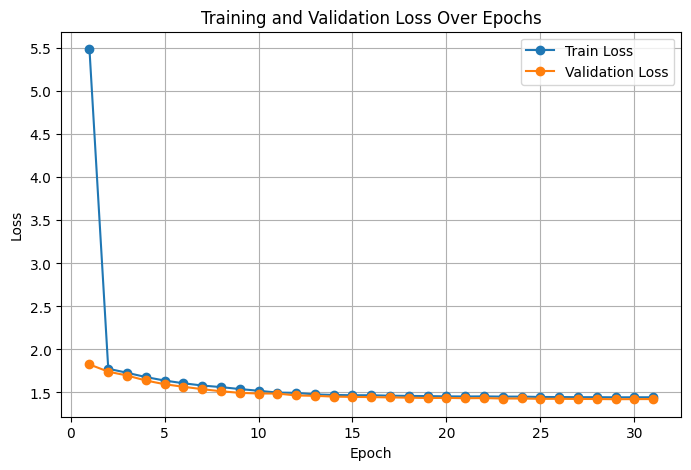

In [48]:
trainloader, valloader, testloader = load_data(batch_size=32)
model_abalone = AbaloneNetworkTwoLayer(10, 12, 1)
device = torch.device("cpu")
model_abalone.to(device)
criterion_l1 = nn.L1Loss()
optimizer_sgd = optim.SGD(model_abalone.parameters(), lr=5e-3, weight_decay=1e-6, momentum=0.9)
epochs = 50
lambda_reg_score = 1e-5
train_loss_list, val_loss_list, epochs_done = train_setup_epochs(train_loader = trainloader,
                                                    val_loader=valloader, 
                                                    model=model_abalone, 
                                                    optimizer=optimizer_sgd, 
                                                    device=device, 
                                                    criterion=criterion_l1, 
                                                    num_epochs=epochs,
                                                    lambda_reg=lambda_reg_score,
                                                    stop_converge=True)
plot_figure(epochs_done, train_loss_list, val_loss_list)

### Create final predictions of the final test.csv


In [ ]:
def create_predicted_csv(model_or_saved, test_loader, device):
    """if you set the model_or_saved to None or False, you use the torch pth file to load the model. You can also provide 
    model as parameter, then it will work based on the provided model"""
    if not model_or_saved:
        model = torch.load("best_model.pth", weights_only=False)
    else:
        model = model_or_saved
    model.eval()
    final_predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            final_predictions.extend([round(float(output), 2) for output in outputs])
    
    final_df = pd.read_csv("data/test.csv")
    final_df["prediction"] = final_predictions
    final_df.to_csv("data/final.csv")
    final_df.to_markdown("final_test.md")

    return "correctly saved into final_test.csv the predictions + original data"

#print(create_predicted_csv(model_abalone, testloader))
print(create_predicted_csv(False, testloader, device))

correctly saved into final_test.csv the predictions + original data


# Notes for the report pdf

### The text below doesn't hava a place in the jupyter notebook so we add remarks during the process

A mistake was made initially where the weight decay was set to 1e4 instead of 1e-4, this led to a frustrating debugging session. The loss values were NaN, and it was hard to find it out. After checking the first couple of loss values. We saw that the loss became increasing exponentially larger, until it was so large that NaN was displayed. This is a great example of exploding gradients. 